In [1]:
# import
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import network_control functions
from network_control.energies import integrate_u, get_control_inputs
from network_control.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from network_control.metrics import ave_control
from network_control.utils import matrix_normalization, convert_states_str2int, normalize_state, normalize_weights, \
    get_null_p, get_fdr_p
from network_control.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines
from null_models.geomsurr import geomsurr

# Protocol Pathway A: Control Energy

### Load A

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/results'
A_file = 'normalized_connection_strength_ipsi.csv'
# A_file = 'connection_strength_ipsi.csv'

In [3]:
# load A matrix
A = np.loadtxt(os.path.join(datadir, A_file), dtype=float, delimiter=',', encoding='utf-8-sig')
A = A.T  # set rows=tagets and columns=sources. That is, Aij = edge from node j to node i

# load region class
region_class = pd.read_csv(os.path.join(datadir, 'region_class.csv'))

# retain isocortex
idx = region_class['Isocortex'] == 1
# subset A
A = A[region_class[idx].index, :][:, region_class[idx].index]
n_nodes = A.shape[0]
print(A.shape)
# subset region_class
region_class = region_class[idx]

# sort on Isocortex_modules
region_class.reset_index(inplace=True, drop=True)
region_class['sort_idx'] = region_class.index
region_class.sort_values('Isocortex_modules', inplace=True)
region_class.reset_index(inplace=True, drop=True)
# sort A to match
A = A[region_class.sort_idx, :][:, region_class.sort_idx]

print(region_class)

(43, 43)
     Region  Class  Isocortex Isocortex_modules  sort_idx
0      AUDv      0          1          Auditory        16
1     AUDpo      0          1          Auditory        15
2      AUDp      0          1          Auditory        14
3      AUDd      0          1          Auditory        13
4       ECT     12          1           Lateral        42
5      PERI     12          1           Lateral        41
6        GU     12          1           Lateral        11
7       AId      0          1           Lateral        32
8      VISC     12          1           Lateral        12
9       AIv      0          1           Lateral        34
10      TEa     12          1           Lateral        40
11      AIp      0          1           Lateral        33
12   RSPagl      0          1            Medial        35
13     RSPd      0          1            Medial        36
14     RSPv      0          1            Medial        37
15     VISa      0          1            Medial        38
16   

### Plot A

['Auditory' 'Lateral' 'Medial' 'PFC' 'Somatomotor' 'Visual']


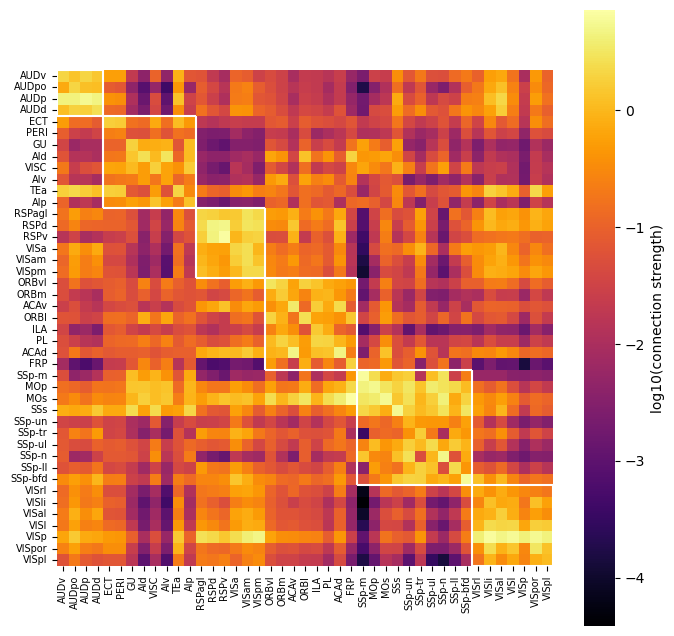

In [4]:
# plot A matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(np.log10(A), ax=ax, square=True, cmap='inferno',
            xticklabels=region_class.Region, yticklabels=region_class.Region,
            cbar_kws={'label': 'log10(connection strength)'})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=7)
add_module_lines(region_class['Isocortex_modules'], ax)
plt.show()

### Assign isocortex to DMN based on Whitesell 2021 Neuron

In [5]:
# Whitesell DMN regions
dmn_regions = [
    'ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl',
    'VISa', 'VISam', 'RSPagl', 'RSPd', 'RSPv',
    'SSp-tr', 'SSp-ll', 'MOs'
]

region_class.set_index('Region', inplace=True)
region_class['DMN'] = np.zeros(n_nodes).astype(bool)
for idx in dmn_regions:
    region_class.loc[idx, 'DMN'] = True
region_class.reset_index(inplace=True, drop=False)

# create new system labels column that uses DMN to overwrite existing modules
region_class['sytem_labels'] = region_class['Isocortex_modules']
region_class['sytem_labels'][region_class['DMN']] = 'DMN'

print(region_class)

     Region  Class  Isocortex Isocortex_modules  sort_idx    DMN sytem_labels
0      AUDv      0          1          Auditory        16  False     Auditory
1     AUDpo      0          1          Auditory        15  False     Auditory
2      AUDp      0          1          Auditory        14  False     Auditory
3      AUDd      0          1          Auditory        13  False     Auditory
4       ECT     12          1           Lateral        42  False      Lateral
5      PERI     12          1           Lateral        41  False      Lateral
6        GU     12          1           Lateral        11  False      Lateral
7       AId      0          1           Lateral        32  False      Lateral
8      VISC     12          1           Lateral        12  False      Lateral
9       AIv      0          1           Lateral        34  False      Lateral
10      TEa     12          1           Lateral        40  False      Lateral
11      AIp      0          1           Lateral        33  False

/var/folders/8_/z_xhkpg925n0zp0dl0yrqmy80000gn/T/ipykernel_27582/3069633426.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_class['sytem_labels'][region_class['DMN']] = 'DMN'


### Get states

In [6]:
# get system labels
system_labels = list(region_class['sytem_labels'])

In [7]:
print(len(system_labels))
print(system_labels[:20])

43
['Auditory', 'Auditory', 'Auditory', 'Auditory', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'DMN', 'DMN', 'DMN', 'DMN', 'DMN', 'Medial', 'DMN', 'DMN']


In [8]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)

### Setup control tasks

In [9]:
# initialize list of control tasks
control_tasks = []

# define control nodes using a uniform full control set
# note, here we use the same control nodes for all control tasks
B = np.eye(n_nodes)

# define state trajectory constraint nodes.
# note, here we constrain the full state trajectory equally for all control tasks
S = np.eye(n_nodes)

# define mixing parameter
rho = 1

x0 = states == state_labels.index('DMN')
x0 = normalize_state(x0)  # normalize state magnitude

# assemble control tasks
for i in ['Lateral', 'Visual', 'Auditory']:
    xf = states == state_labels.index(i)
    xf = normalize_state(xf)  # normalize state magnitude

    # i to j
    control_task = dict()  # initialize dict
    control_task['x0'] = x0  # store initial state
    control_task['xf'] = xf  # store target state
    control_task['B'] = B  # store control nodes
    control_task['S'] = S  # store state trajectory constraints
    control_task['rho'] = rho  # store rho
    control_tasks.append(control_task)

    # j back to i
    control_task = dict()  # initialize dict
    control_task['x0'] = xf  # store initial state
    control_task['xf'] = x0  # store target state
    control_task['B'] = B  # store control nodes
    control_task['S'] = S  # store state trajectory constraints
    control_task['rho'] = rho  # store rho
    control_tasks.append(control_task)

### Run ComputeControlEnergy

In [10]:
# compute control energy across all control tasks
compute_control_energy = ComputeControlEnergy(A=A,
                                              control_tasks=control_tasks,
                                              system='continuous',
                                              c=1,
                                              T=1)
compute_control_energy.run()

# reshape to set DMN-to-X on first column and X-to-DMN on second column
E = np.reshape(compute_control_energy.E, (3, 2))  # reshape energy
E_d = E[:, 1] - E[:, 0]  # get energy asymmetries
print(E)
print(E_d)

100%|██████████| 6/6 [00:00<00:00, 80.84it/s]

[[2724.37609829 1944.85054695]
 [2406.76108952 2211.65778753]
 [2437.44752492 2081.29461031]]
[-779.52555135 -195.10330199 -356.15291461]


### Re-run ComputeControlEnergy using symmetric mouse connectome

In [11]:
As = A + A.T  # symmetrize mouse connectome

# compute control energy across all control tasks
compute_control_energy = ComputeControlEnergy(A=As,
                                              control_tasks=control_tasks,
                                              system='continuous',
                                              c=1,
                                              T=1)
compute_control_energy.run()

# reshape to set DMN-to-X on first column and X-to-DMN on second column
E_As = np.reshape(compute_control_energy.E, (3, 2))  # reshape energy
E_As_d = E_As[:, 1] - E_As[:, 0]  # get energy asymmetries
print(E_As)
print(E_As_d)

100%|██████████| 6/6 [00:00<00:00, 118.74it/s]

[[2633.70888488 1970.22073773]
 [2312.00442949 2128.9371374 ]
 [2370.82526775 2100.39764887]]
[-663.48814714 -183.06729209 -270.42761888]


In [12]:
# get differences in energy asymmetries between directed and undirected connectome
asym_dif = np.abs(E_d) - np.abs(E_As_d)
print(asym_dif)

# get percent change in energy asymmetries
def perc_change(x, y):
    return np.round((y - x) / np.abs(x) * 100)

asym_dif_perc = []
for i in np.arange(len(asym_dif)):
    asym_dif_perc.append(perc_change(np.abs(E_As_d[i]), np.abs(E_d[i])))
print(asym_dif_perc)

[116.0374042   12.0360099   85.72529573]
[17.0, 7.0, 32.0]


## Plot results

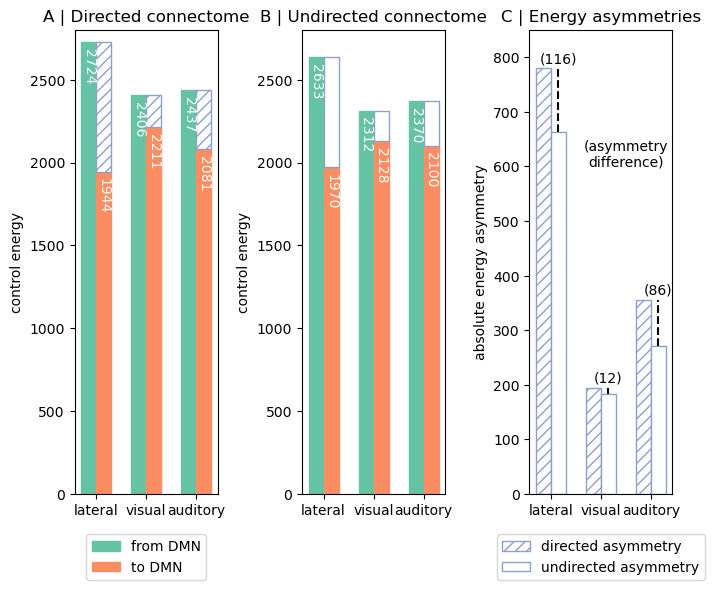

In [13]:
cmap = sns.color_palette("Set2")

labels = ['lateral', 'visual', 'auditory']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

f, ax = plt.subplots(1, 3, figsize=(7.15, 6))

# directed adjacency matrix
rects1 = ax[0].bar(x - width/2, E[:, 0], color=cmap[0], edgecolor=cmap[0], width=width, label='from DMN')
rects2 = ax[0].bar(x + width/2, E[:, 1], color=cmap[1], edgecolor=cmap[1], width=width, label='to DMN')
rects3 = ax[0].bar(x + width/2, np.abs(E_d), bottom=E[:, 1], color='w', edgecolor=cmap[2],
                   hatch='///', width=width)

ax[0].set_title('A | Directed connectome')
ax[0].set_ylabel('control energy')
ax[0].set_xticks(x, labels)
ax[0].legend(bbox_to_anchor=(0.5, -0.2), loc='lower center')
ax[0].set_ylim([0, 2800])

ax[0].bar_label(rects1, padding=-30, fmt='%i', rotation=270, color='w')
ax[0].bar_label(rects2, padding=-30, fmt='%i', rotation=270, color='w')

# undirected adjacency matrix
rects1 = ax[1].bar(x - width/2, E_As[:, 0], color=cmap[0], edgecolor=cmap[0], width=width, label='from DMN')
rects2 = ax[1].bar(x + width/2, E_As[:, 1], color=cmap[1], edgecolor=cmap[1], width=width, label='to DMN')
rects3 = ax[1].bar(x + width/2, np.abs(E_As_d), bottom=E_As[:, 1], color='w', edgecolor=cmap[2],
                   width=width, label='Asymmetry (abs.)')

ax[1].set_title('B | Undirected connectome')
ax[1].set_ylabel('control energy')
ax[1].set_xticks(x, labels)
ax[1].set_ylim([0, 2800])

ax[1].bar_label(rects1, padding=-30, fmt='%i', rotation=270, color='w')
ax[1].bar_label(rects2, padding=-30, fmt='%i', rotation=270, color='w')

# asymmetries
rects1 = ax[2].bar(x - width/2, np.abs(E_d), color='w', edgecolor=cmap[2],
                   hatch='///', width=width, label='directed asymmetry')
rects2 = ax[2].bar(x + width/2, np.abs(E_As_d), color='w', edgecolor=cmap[2],
                   width=width, label='undirected asymmetry')

ax[2].set_title('C | Energy asymmetries')
ax[2].set_ylabel('absolute energy asymmetry')
ax[2].set_xticks(x, labels)
ax[2].set_ylim([0, 850])

for i, p in enumerate(rects2):
    height = p.get_height()
    ax[2].text(x=p.get_x() + p.get_width() / 2, y=height + asym_dif[i] + 10, s='({:.0f})'.format(asym_dif[i]), ha='center')
    ax[2].axvline(x=p.get_x() + p.get_width()/2, ymin=height/850, ymax=(height+asym_dif[i])/850,
                  color='k', linestyle='--')
ax[2].text(x=1.5, y=600, s='(asymmetry\ndifference)', ha='center')
ax[2].legend(bbox_to_anchor=(0.5, -0.2), loc='lower center')

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'mouse_energy.png'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()
